<a href="https://colab.research.google.com/github/Zsadoune/zsadoune.github.io/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports needed 

In [1]:
# numerical library:
import numpy as np

# data manipulation library:
import pandas as pd

# standard packages used to handle files:
import sys
import os 
import glob
import time

# scikit-learn machine learning library:
from sklearn import preprocessing

# plotting:
import matplotlib.pyplot as plt

# MODELS 
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet , Lasso , Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# to avoid unwanted warnings while fitting
import warnings
from sklearn.exceptions import ConvergenceWarning

import math

# tell matplotlib that we plot in a notebook:
%matplotlib inline

#Importing the data 
The data is represented in training data ( used for training the model ) and testing data , that cannot be used in the training process . Also , the testing data doesn't contain the target value feature . 

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# DATA PREPARATION 
## Numerise data 
We can see from the data that a few features are not numerical . We absolutely need to numerise them , to make them work on our models . The numerisation is done by LabelEncoder : we attribute incremented values to each alphabetical value of the feature . For that we first need to know the different values that the feature takes in the initial dataset , for example Spring , Summer , Winter and Automn for the Season feature.
The same work is done on the following features : Seasons , Holiday , Functioning Day . 

In [4]:
# DATA NUMERISATION
def norm_DSHF(train_sample , test_sample) :
  enc = preprocessing.LabelEncoder()
  enc.fit(['Winter', 'Spring', 'Summer', 'Autumn'])

  enc2 = preprocessing.LabelEncoder()
  enc2.fit(['No Holiday', 'Holiday'])

  enc3 = preprocessing.LabelEncoder()
  enc3.fit(['Yes', 'No'])

  train_sample['Seasons'] = enc.transform(train_sample['Seasons'])
  train_sample['Holiday'] = enc2.transform(train_sample['Holiday'])
  train_sample['Functioning Day'] = enc3.transform(train_sample['Functioning Day'])

  test_sample['Seasons'] = enc.transform(test_sample['Seasons'])
  test_sample['Holiday'] = enc2.transform(test_sample['Holiday'])
  test_sample['Functioning Day'] = enc3.transform(test_sample['Functioning Day'])

norm_DSHF(train_data , test_data)


## Data transformation
###Transform Date values , to fully numerical 
We can see from the data samples that Date values are String dates , in the form "dd/mm/year" . Our model again cannot process Strings , so we decide to change something . 

A first idea that comes to mind is to just take off the '/' from the Strings .  By doing that , the feature looses the order relation between the dates , example : 22012017 will look very close to 22012018 , even after scaling ( we'll talk more about this later )  , which is not correct . Instead , we can create a feature for each part of the date , and let the model treat them differently : date = day | month | year . This is called feature extraction . The downfall of performing data extraction is that we add new features , but it is worth it if it helps our model understand better the data . For this case we clearly need to do something about the date feature . 

All these data changes that we're making need to be done on the training and also the testing sample , it becomes part of our model . 

In [5]:
def date_separation(date_in_string) :
  res = date_in_string.split('/') 
  return [int(res[0]) , int(res[1]) , int(res[2])]

In [6]:
# EXTRACTING DAY , MONTH , YEAR FROM training data 
dates = train_data["Date"].values
dates = list(dates)
resD = []
resM = []
resY  = []
for elem in dates : 
  separated = date_separation(elem)
  resD.append(separated[0])
  resM.append(separated[1])
  resY.append(separated[2])
  
# EXTRACTING DAY , MONTH , YEAR FROM training data   
datesTes = test_data["Date"].values
datesTes = list(datesTes)
resD_tst = []
resM_tst = []
resY_tst  = []
for elem in datesTes : 
  separated = date_separation(elem)
  resD_tst.append(separated[0])
  resM_tst.append(separated[1])
  resY_tst.append(separated[2])

# UPDATING THE DATA WITH NEW COLUMNS ( features )
train_data["Day"] = resD ; train_data["Month"] = resM ; train_data["Year"] = resY ;
test_data["Day"] = resD_tst ; test_data["Month"] = resM_tst ; test_data["Year"] = resY_tst ;

# DROPING THE INITIAL DATE FEATURE
train_data = train_data.drop(["Date"] , axis = 1)
test_data = test_data.drop(["Date"], axis = 1)



### Target values from training data 
Just like we said before , the training data already contains the target feature , which we want to extract in a seprate data sample . The testing sample doesn't have a any  target values to extract . 
The final samples used for training , tuning and testing the model are 
  - X_train : the training sample 
  - r_train : the target value corresponding to the training sample 
  - test_data : the testing sample , no target values 

### Log/Expo transformation 
By using linear models or even neural networks , we can get negative target values from a sample full of only positive ones , juste like in our case ( E-scouter Count > 0 ) . Some models have parameter specifying if we allow any range for our data , which forces it to give positive values for example . Unfortunately most of the linear models do not have this option , which means we'll need to adopt a strategy to to avoid negative values . 

The most common way of doing it is the logarithmic transformation : We change our target value to logarithmic values , and the prediction will have the same form naturally . To get the actual predicted value , we apply exponential function on the target feature . This way , all the values will be positive . Also , to avoid getting -inf values for when passing the logarithmic function on a value of 0 , we actually add 0.01 before calculating the log . It makes a slight change in the data but it is very small , and therefore insignificant . The value 0.01 is choosen randomly , as long as it keeps the predicted value after applying an exponential function very close to 0 . 
Note that for all the predictions we're getting next , the expo/ln transfo was used . 

In [7]:

# Data Separation : parameters/target

r_train_no_expo = train_data["E-scooter Count"] 

X_train = train_data.drop(["E-scooter Count"] , axis=1)
r_train = np.log(train_data["E-scooter Count"] + 0.01)

#X_train = X_train.drop(["Day"] , axis = 1)
#test_data = test_data.drop(["Day"], axis = 1)



## Is the Day feature important ? 

### DATA VISUALISATION 
We can plot the correlation matrix to see patterns or strong relation between features , also detect the importance of each feature for the target value . 

In [9]:


def plot_correlation_matrix(df):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
    plt.jet() # set the colormap to jet
    cax = ax.matshow(df.corr(), vmin=-1, vmax=1)

    ticks = list(range(len(df.columns)))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.set_xticklabels(df.columns, rotation=90, horizontalalignment='left')
    ax.set_yticklabels(df.columns)
    
    fig.colorbar(cax, ticks=[-1.0,-0.75,-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])

    plt.tight_layout()
    plt.show()


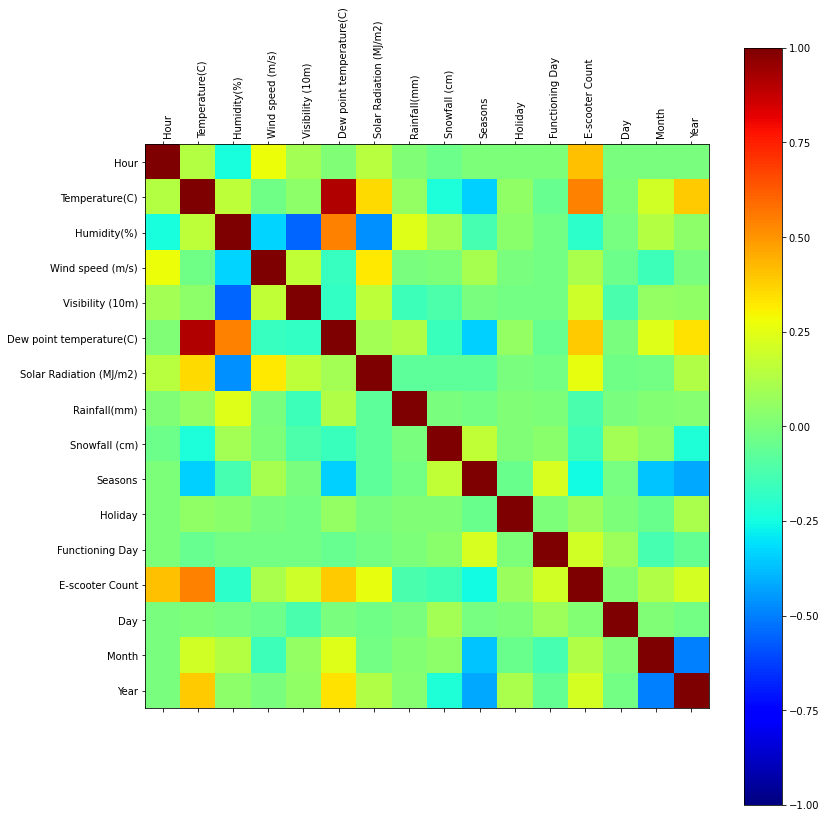

In [10]:
plot_correlation_matrix(train_data)

#Correlation Analysis
First of all , we detect a strong correlation between "Temperature" and "Dew point temperature" , which indicates that they contain the same information . When we have two features with that strong of a correlation , we can take out one of them from the data sample . Another interesting point is that we do not have many strong correlations , which indicates that our model might not perform the best with a linear regression algorithm . It would then be intersting to test a non-linear model . 

We can see a weak correlation between "Month" and "Season" , isn't weird ? The season depends directly on the month , which means that these two features should show a strong correlation . Actually , the correlation is weak because the "Season" feature has been numerised following an encoding that attributes the values in the order they appear on the dataset , which looses the order of magnitude and therefore doesn't correlate to the months anymore . 



Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8b06f7f70>,
      dtype=object)

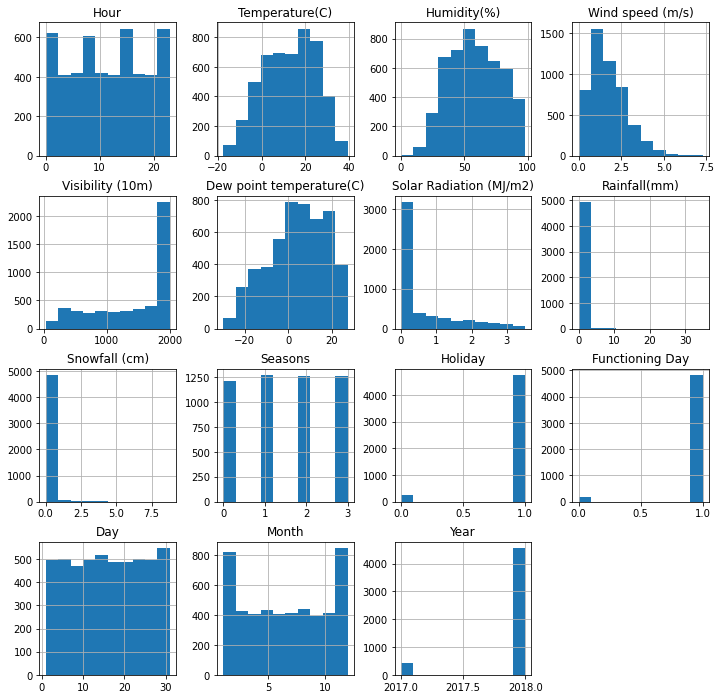

In [8]:
X_train.hist(figsize= (12,12)) # figsize: (width,height)

#Model choice 
To choose the models we test , we can rely on sklearn's cheat-sheet : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

We want to try a few models that match the most with our data , as we can see from the graph in the link that . First , our problem is a regression problem , and our training data is > 100k samples . Therefore, Lasso and ElasticNet and RidgeRegression are interresting models to try . 

To compare these three basic linear models , we want to try the default version first , to see which one performs better without tuning . To be able able to compare , we want to use exactly the same data samples , either from training or for testing . 


In [ ]:

firstModel = ElasticNet()
secondModel = Lasso()
thirdModel = Ridge()



# Testing the models without tuning 
We can start by making a simple evaluation for the models , and for that we can use the cross validation method . We choose as a strategy to specify 10 folds . Generally , 5 is the most used , but since we are just testing for a first impression , we want to increse this parameter to have a more accurate average score at the end . 

In [ ]:

# save the results of predictions in a list . 

for model in [firstModel , secondModel , thirdModel] :
  scores4 = cross_val_score(model, X_train, r_train, cv=10)
  print(scores4)
  print("Average accuracy of  ", model , "is ", scores4.mean(), ", stdev: ", scores4.std())


We can see from the results that the linear models Lasso perform slightly better in a cross-validation evaluation than Ridge , and much better than ElasticNet . We choose then to go with Lasso for our model .   

In [ ]:
def tune_lasso(x_data,r_data):
    pipe = Pipeline([
        ('scale',StandardScaler()),
        ('model',Lasso())
    ])

    # Set the parameters by cross-validation
    tuned_parameters = [{"model__fit_intercept" : [True , False] , "model__alpha" : [0.1 , 1 , 2]}]

    CV = GridSearchCV(pipe, tuned_parameters, cv=5)
    CV.fit(x_data, r_data)
    best_fit = CV.best_params_['model__fit_intercept']
    best_alpha = CV.best_params_['model__alpha']
    print("Optimal regularisation value: ",best_fit , best_alpha)
    optimal_pipe = Pipeline([
        ('scale',StandardScaler()),
        ('model',Lasso(fit_intercept = best_fit , alpha = best_alpha ))
    ])
    
    return optimal_pipe

Additionally to these linear models , we want to try neural networks  (NN) . The nature of our data ( multiple features ) suggests that using multiple layers algorithms could give a good result . MLPRegressor is sklearn supervised model that can be used for either classification or regression , it learns a non-linear function to predict a target feature also called output .The sensitive point of MLPReg is that it relies a lot on the scaling used on the data , it would be interesting to try with different scaling methods too . Also , to achieve good results with NN , tuning the model is necessary . For more information about MLPRegression : https://scikit-learn.org/stable/modules/neural_networks_supervised.html .

In [ ]:
fourthModel = Lasso()

In [ ]:
secondModel.fit(X_train,r_train)
r_test = secondModel.predict(test_data)

# Tuning the model with hyper parameters 

In [ ]:
new_db = X_train.loc[:,X_train.columns != "Day"]
new_db = X_train.loc[: ,X_train.columns != "Dew point temperature(C)"]
test_data = test_data.loc[:,test_data.columns != "Day"]
test_data = test_data.loc[: ,test_data.columns != "Dew point temperature(C)"]


print(new_db.head())


   Hour  Temperature(C)  Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
0    22            13.6           38               1.5              2000   
1     0           -10.4           49               2.4              2000   
2    20            33.5           50               2.1              2000   
3     0            21.8           83               1.5              2000   
4     6             1.1           78               1.1               538   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  \
0                     0.00           0.0            0.0        0        1   
1                     0.00           0.0            0.0        3        1   
2                     0.04           0.0            0.0        2        1   
3                     0.00           0.0            0.0        0        1   
4                     0.00           0.0            0.0        1        1   

   Functioning Day  Month  Year  
0                1     10  2018  
1           

In [ ]:

nb_features = X_train.shape[1]
f_scores = np.zeros(nb_features)

for idx in range(nb_features):
    selector = SelectKBest(f_regression, k=idx+1).fit(X_train, r_train)
    x_new=selector.transform(X_train)
    s_model = tune_lasso(x_new, r_train)
    f_scores[idx] = cross_val_score(s_model, x_new, r_train, cv=5).mean()
    print("Average accuracy with ", idx+1, " features: ", f_scores[idx])

best_features = np.argmax(f_scores)
print("Optimal performance of ", f_scores[best_features],
      ", for ", best_features+1, " features")

Optimal regularisation value:  True 0.1
Average accuracy with  1  features:  0.7343277371767372
Optimal regularisation value:  True 0.1
Average accuracy with  2  features:  0.8128622229420251
Optimal regularisation value:  True 0.1
Average accuracy with  3  features:  0.8355985520027358
Optimal regularisation value:  True 0.1
Average accuracy with  4  features:  0.8392185546787274
Optimal regularisation value:  True 0.1
Average accuracy with  5  features:  0.8578499360601283
Optimal regularisation value:  True 0.1
Average accuracy with  6  features:  0.8578499360601283
Optimal regularisation value:  True 0.1
Average accuracy with  7  features:  0.8688659675262489
Optimal regularisation value:  True 0.1
Average accuracy with  8  features:  0.8688600795808015
Optimal regularisation value:  True 0.1
Average accuracy with  9  features:  0.8688600795808012
Optimal regularisation value:  True 0.1
Average accuracy with  10  features:  0.8688601167844162
Optimal regularisation value:  True 0.1

In [ ]:


def tune_rescaled_model(x_data,r_data):
    pipe = Pipeline([
        ('scale',StandardScaler()),
        ('model',MLPRegressor(max_iter = 400))
    ])

    # Set the parameters by cross-validation
    tuned_parameters = [{'model__hidden_layer_sizes': [(10 , 10) , (20,20)] ,'model__solver':["lbfgs" ,"sgd" , "adam"]}]

    CV = GridSearchCV(pipe, tuned_parameters, cv=5)
    CV.fit(x_data, r_data)
    best_layers = CV.best_params_['model__hidden_layer_sizes']
    best_solver = CV.best_params_['model__solver']
    print("Optimal regularisation value: ",best_layers , best_solver)
    optimal_pipe = Pipeline([
        ('scale',StandardScaler()),
        ('model',MLPRegressor(hidden_layer_sizes = best_layers , max_iter = 400 , solver = best_solver))
    ])
    
    return optimal_pipe



#Best features selection

#K-Cross validation with tuned model 

In [ ]:

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    selector = SelectKBest(f_regression, k=best_features+1).fit(X_train, r_train)
    select_model = tune_lasso(selector.transform(X_train), r_train)
    scoreslin = cross_val_score(select_model, selector.transform(X_train), r_train, cv=5)
    print(scoreslin)
    print("Average CV accuracy of linear model: ",scoreslin.mean(),", stdev: ",scoreslin.std())

    select_model.fit(selector.transform(X_train), r_train)
    r_test = select_model.predict(selector.transform(test_data))

    train_score_select = select_model.score(selector.transform(X_train), r_train)
    test_score_select = select_model.score(selector.transform(test_data), r_test)

    print("Accuracy of final model: ",train_score_select,
          " (train), ",test_score_select," (test)")

Optimal regularisation value:  True 0.1
[0.85648859 0.90076671 0.86809175 0.89798775 0.85798673]
Average CV accuracy of linear model:  0.8762643046651813 , stdev:  0.019309145913252092


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- Dew point temperature(C)

  warnings.warn(message, FutureWarning)


ValueError: ignored

In [ ]:
print(r_test)

[6.37934806 6.42100295 6.04210888 ... 6.98638868 5.22023614 5.9383689 ]


In [ ]:

submission = pd.DataFrame(data=r_test, columns=["Predicted"])
submission.reset_index(inplace=True)
submission = submission.rename(columns = {'index':'Id'})
submission["Predicted"] = np.exp(submission["Predicted"])
submission.head()

submission["Predicted"].mean()




519.9235136988243

In [ ]:
def generate_unique_filename(basename, file_ext):
    """Adds a timestamp to filenames for easier tracking of submissions, models, etc."""
    timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    return basename + '_' + timestamp + '.' + file_ext
submission.to_csv(generate_unique_filename("firstSub", "csv"), index=False)